In [2]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.8 MB/s eta 0:00:006.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 19.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 19.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 18.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 19.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.3/257.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 13.0 MB/s eta 0:

# Linear regression from scratch

Now that you understand the key ideas behind gradient descent optimization, we can begin to work through a hands-on implementation of linear regression in code. In this section, we will implement the entire method from scratch, including the data pipeline, the model, the loss function, and the minibatch stochastic gradient descent optimizer. While modern deep learning frameworks can automate nearly all of this work, implementing things from scratch is the only way to make sure that you really know what you are doing. Moreover, when it comes time to customize models, defining our own layers or loss functions, understanding how things work under the hood will prove handy. In this section, we will rely only on tensors and auto differentiation; in the next notebook, you will see a more concise implementation, taking advantage of the Pytorch deep learning framework.

In [3]:
%matplotlib inline
from d2l import torch as d2l
import torch
import random

## Generating the dataset

To keep things simple, we will construct an artificial dataset according to a linear model with additive noise.
Our task will be to recover this model's parameters using the finite set of examples contained in our dataset.
We will keep the data low-dimensional so we can visualize it easily. In the following code snippet, we generate a dataset containing 1,000 examples, each consisting of 2 features sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

The true parameters generating our dataset will be $\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and our synthetic labels will be assigned according to the following linear model with the noise term $\epsilon$:

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$

You could think of $\epsilon$ as capturing potential measurement errors on the features and labels. We will assume that the standard assumptions hold and thus that $\epsilon$ obeys a normal distribution with mean of 0.
To make our problem easy, we will set its standard deviation to 0.01. The following code generates our synthetic dataset.

In [57]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [58]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note that each row in `features` consists of a 2-dimensional data example
and that each row in `labels` consists of a 1-dimensional label value (a scalar).


In [59]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.9817, -1.5924]) 
label: tensor([11.5771])


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


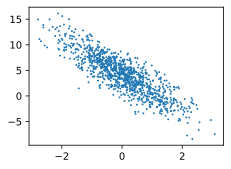

In [60]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

## Reading the dataset

Recall that training models consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model. Since this process is so fundamental to training machine learning algorithms, it is worth defining a utility function to shuffle the dataset and access it in minibatches.

In the following code, we define the `data_iter` function to demonstrate one possible implementation of this functionality. The function takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of the size `batch_size`. Each minibatch consists of a tuple of features and labels.

In [16]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        # If you don't know about 'yield', check
        # https://www.geeksforgeeks.org/use-yield-keyword-instead-return-keyword-python/

In general, note that we want to use reasonably sized minibatches to take advantage of the GPU hardware, which excels at parallelizing operations. Because each example can be fed through our models in parallel and the gradient of the loss function for each example can also be taken in parallel, GPUs allow us to process hundreds of examples in scarcely more time than it might take to process just a single example.

To build some intuition, let us read and print the first small batch of data examples. The shape of the features in each minibatch tells us both the minibatch size and the number of input features. Likewise, our minibatch of labels will have a shape given by `batch_size`.

In [55]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.2124, -0.4706],
        [-0.6910, -1.2100],
        [-0.3774,  0.1511],
        [ 0.6404,  1.4246],
        [-0.4909, -0.5458],
        [-0.3719,  0.4999],
        [ 0.2689, -1.7650],
        [-1.0722,  1.7705],
        [-0.4487, -0.0432],
        [ 0.4693, -0.8140]]) 
 tensor([[ 5.3728],
        [ 6.9232],
        [ 2.9292],
        [ 0.6327],
        [ 5.0610],
        [ 1.7551],
        [10.7382],
        [-3.9496],
        [ 3.4463],
        [ 7.9053]])


### Exercise 1

If the number of examples cannot be divided by the batch size, what happens to the `data_iter` function's behavior?

*it will give you the remainder*

## Initializing model parameters

Before we can begin optimizing our model's parameters by minibatch stochastic gradient descent, we need to have some parameters in the first place. In the following code, we initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.

In [34]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### Exercise 2

Reason what would happen if we were to initialize the weights $\mathbf{w}$ using a very high value. After going through the code below, you can get back to the initialization above and try yourself what happens with high values for the weights at the start.

*If using very high values for weights then the loss function will be very large (the euclidean distance) gradient descent needs to traverse large distances and takes a long time computationally*.

After initializing our parameters, our next task is to update them until they fit our data sufficiently well.
Each update requires taking the gradient of our loss function with respect to the parameters. This is calculated using automatic differentiation. Given this gradient, we can update each parameter in the direction that may reduce the loss.

## Defining the model

Next, we must define our model, relating its inputs and parameters to its outputs. Recall that to calculate the output of the linear model, we simply take the matrix-vector dot product of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$, and add the offset $b$ to each example. Note that below $\mathbf{Xw}$  is a vector and $b$ is a scalar. Note that when we add a vector and a scalar, broadcasting ensures that the scalar is added to each component of the vector.

In [51]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

## Defining the loss function

Since updating our model requires taking the gradient of our loss function, we ought to define the loss function first. Here we will use the squared loss function. In the implementation, we need to transform the true value `y` into the predicted value's shape `y_hat`. The result returned by the following function
will also have the same shape as `y_hat`.

In [52]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## Defining the optimization algorithm

At each step, using one minibatch randomly drawn from our dataset, we will estimate the gradient of the loss with respect to our parameters. Next, we will update our parameters in the direction that may reduce the loss. The following code applies the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size. The size of the update step is determined by the learning rate `lr`. Because our loss is calculated as a sum over the minibatch of examples, we normalize our step size by the batch size (`batch_size`), so that the magnitude of a typical step size does not depend heavily on our choice of the batch size.

In [53]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training

Now that we have all of the parts in place, we are ready to implement the main training loop. It is crucial that you understand this code because you will see nearly identical training loops over and over again throughout your career in deep learning.

In each iteration, we will grab a minibatch of training examples, and pass them through our model to obtain a set of predictions. After calculating the loss, we initiate the backwards pass through the network, storing the gradients with respect to each parameter. Finally, we will call the optimization algorithm `sgd` to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*, we will iterate through the entire dataset (using the `data_iter` function) once passing through every example in the training dataset (assuming that the number of examples is divisible by the batch size). The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters, which we set here to 5 and 0.03, respectively. Unfortunately, setting hyperparameters is tricky and requires some adjustment by trial and error.

In [63]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss nan
epoch 2, loss nan
epoch 3, loss nan
epoch 4, loss nan
epoch 5, loss nan


In this case, because we synthesized the dataset ourselves, we know precisely what the true parameters are. Thus, we can evaluate our success in training by comparing the true parameters with those that we learned through our training loop. Indeed they turn out to be very close to each other.

In [62]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([nan, nan], grad_fn=<SubBackward0>)
error in estimating b: tensor([nan], grad_fn=<RsubBackward1>)


### Exercise 3

Experiment using different learning rates to find out how fast the loss function value drops. Note: if you just rerun the code immediately above, you will seem to have a very low loss already at the start... but that is because you then use the previously found estimate for `w` and `b` as starting point! Think about what you should do to prevent this.

*playing around with the learning rate we can see that if we change the value to 10 the training will never reach the optima as it will overshoot*

In [61]:
lr = 0.1
num_epochs = 20
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss nan
epoch 2, loss nan
epoch 3, loss nan
epoch 4, loss nan
epoch 5, loss nan
epoch 6, loss nan
epoch 7, loss nan
epoch 8, loss nan
epoch 9, loss nan
epoch 10, loss nan
epoch 11, loss nan
epoch 12, loss nan
epoch 13, loss nan
epoch 14, loss nan
epoch 15, loss nan
epoch 16, loss nan
epoch 17, loss nan
epoch 18, loss nan
epoch 19, loss nan
epoch 20, loss nan
